In [1]:
cd ../../src

/Users/in-divye.singh/Documents/Projects/MIC_predictor/src


In [2]:
import biovec
import numpy as np
import pandas as pd
from itertools import chain, combinations
from collections import Counter

from utils import *

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from Bio.SeqUtils.ProtParam import ProteinAnalysis

In [3]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [4]:
avp_ic50 = pd.read_csv("../data/raw/AVP-IC50Pred_train.csv")
ha_avp = pd.read_csv("../data/raw/HA_AVP.csv")

In [5]:
df = pd.concat([avp_ic50[['Sequence','MIC']], ha_avp], axis=0).drop_duplicates(['Sequence']).reset_index(drop=True)
df = sequence_filtering(df)

In [6]:
df

,Sequence,MIC
0,AAQRRGRVGRNPNQVGD,442.00000
1,HRILARIRQMMT,435.50000
2,RNPSQVGD,383.00000
3,RVGRNPNQVGD,374.00000
4,AAQRRGRIGRNPSQVGD,358.00000
...,...,...
707,NGAICWGPCPTAFRQIGNCGHFKVRCCKIR,0.11515
708,CFPYITRPGTYHDWWYTRKNRQ,0.30000
709,YTSLIHSLIEESQNQQEKNEQELLELDKWASLWNWF,0.01131
710,GTNLSVPNPLGFFPDHQLDPAFGANSNNPDWDFNPNKDHWPEANKVG,0.00008


In [7]:
def get_physicochemical_properties(df):
    params = ['aromaticity', 'helix', 'turn', 'sheet', 'gravy', 'net_charge_at_pH7point4']

    prop = []
    for seq in df.Sequence:
        X = ProteinAnalysis(seq)
        aromaticity = X.aromaticity()
        sec_struc = X.secondary_structure_fraction()
        helix = sec_struc[0]
        turn = sec_struc[1]
        sheet = sec_struc[2]
        gravy = X.gravy() # hydrophobicity related
        net_charge_at_pH7point4 = X.charge_at_pH(7.4)

        prop.append([aromaticity, helix, turn, sheet, gravy, net_charge_at_pH7point4])
    return pd.DataFrame(prop, columns=params)

In [8]:
aa_freq = reduce_by_kmer_frequency(df)

In [9]:
uniprot_embedding = biovec.models.load_protvec("../data/embeddings/uniprot__kmer_3_contextWindow_10_vector_100_reduction_None")

avg_protvec = convert_sequences_to_avg_vectors(df['Sequence'], uniprot_embedding, kmer=3)
avg_protvec = avg_protvec.reset_index(drop=True)

/Users/in-divye.singh/anaconda3/envs/life-science/lib/python3.6/site-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
Creating vectors: 100%|██████████| 712/712 [00:00<00:00, 1165.34sequence/s]


In [10]:
physicochemical_prop = get_physicochemical_properties(df)

In [11]:
X = pd.concat([aa_freq, avg_protvec, physicochemical_prop[['helix','turn','sheet']]], axis=1)

In [12]:
y = df['MIC']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
import smogn

In [20]:
train_data = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)

In [21]:
train_data

,A,C,D,E,F,G,H,I,K,L,...,94,95,96,97,98,99,helix,turn,sheet,MIC
0,0.000000,0.000000,0.100000,0.050000,0.050000,0.000000,0.000000,0.150000,0.100000,0.050000,...,-0.005849,0.087767,0.005688,-0.027346,0.034154,-0.083899,0.400000,0.150000,0.150000,4.800
1,0.085714,0.000000,0.085714,0.085714,0.057143,0.000000,0.028571,0.085714,0.057143,0.085714,...,0.031015,0.032227,0.008117,-0.013798,0.076746,-0.089298,0.285714,0.285714,0.257143,6.000
2,0.000000,0.055556,0.166667,0.055556,0.055556,0.000000,0.000000,0.111111,0.055556,0.111111,...,0.019068,0.020467,0.033806,-0.019850,0.056302,-0.008504,0.500000,0.111111,0.166667,0.480
3,0.000000,0.222222,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.111111,0.111111,...,0.048005,0.002872,-0.082759,-0.005556,0.080306,-0.058702,0.333333,0.111111,0.111111,263.000
4,0.100000,0.000000,0.050000,0.150000,0.050000,0.050000,0.000000,0.050000,0.150000,0.150000,...,0.029429,0.007463,0.025750,0.016060,0.065959,-0.061276,0.300000,0.150000,0.400000,17.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,0.114286,0.000000,0.085714,0.057143,0.000000,0.057143,0.028571,0.085714,0.057143,0.171429,...,0.001326,0.012253,-0.003046,-0.013126,0.046634,-0.040752,0.342857,0.200000,0.342857,100.000
565,0.076923,0.000000,0.076923,0.076923,0.076923,0.076923,0.000000,0.230769,0.153846,0.076923,...,-0.017616,0.043828,0.014473,0.008967,0.023963,-0.075192,0.461538,0.153846,0.230769,65.800
566,0.000000,0.071429,0.142857,0.071429,0.000000,0.000000,0.000000,0.142857,0.000000,0.142857,...,0.052798,0.071541,0.006598,-0.045672,0.060443,0.005916,0.571429,0.071429,0.214286,11.300
567,0.000000,0.000000,0.000000,0.000000,0.136364,0.136364,0.181818,0.136364,0.045455,0.045455,...,-0.038070,-0.010218,-0.052157,-0.000562,0.053453,-0.042426,0.454545,0.136364,0.045455,2.100


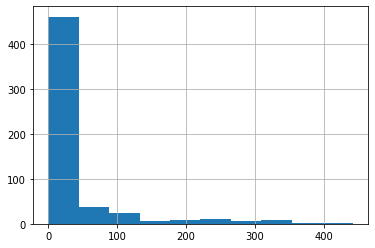

In [24]:
train_data['MIC'].hist()

In [176]:
data_smogn = smogn.smoter(
    data = train_data,
    y = 'MIC',
    k = 1,                    ## positive integer (k < n)
    samp_method = 'extreme',  ## string ('balance' or 'extreme')

    ## phi relevance arguments
    rel_thres = 0.95,         ## positive real number (0 < R < 1)
    rel_method = 'auto',      ## string ('auto' or 'manual')
    rel_xtrm_type = 'high',   ## string ('low' or 'both' or 'high')
    rel_coef = 2.25
)

r_index: 100%|##########| 64/64 [00:00<00:00, 243.84it/s]


In [177]:
data_smogn

,A,C,D,E,F,G,H,I,K,L,...,94,95,96,97,98,99,helix,turn,sheet,MIC
0,0.056440,0.000000,0.036736,0.076144,0.019704,0.083602,0.031949,0.095848,0.063899,0.132584,...,0.001741,0.028419,-0.028116,-0.002754,0.055961,-0.055205,0.363687,0.243349,0.284871,85.149736
1,0.076122,0.000000,0.069665,0.082578,0.006456,0.065813,0.029678,0.089035,0.059357,0.158700,...,-0.000311,0.016124,-0.008040,-0.009645,0.047893,-0.047862,0.349683,0.214204,0.323857,85.149736
2,0.067007,0.000000,0.054416,0.079598,0.012591,0.074051,0.030730,0.092190,0.061460,0.146605,...,0.000639,0.021818,-0.017338,-0.006454,0.051629,-0.051263,0.356168,0.227701,0.305802,85.149736
3,0.082590,0.000000,0.080487,0.084693,0.002103,0.059967,0.028932,0.086796,0.057864,0.167283,...,-0.000986,0.012083,-0.001443,-0.011909,0.045241,-0.045448,0.345080,0.204626,0.336669,85.149736
4,0.059990,0.000000,0.042675,0.077304,0.017315,0.080394,0.031540,0.094619,0.063079,0.137294,...,0.001371,0.026201,-0.024495,-0.003997,0.054506,-0.053881,0.361161,0.238092,0.291902,85.149736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,0.114286,0.000000,0.085714,0.057143,0.000000,0.057143,0.028571,0.085714,0.057143,0.171429,...,0.001326,0.012253,-0.003046,-0.013126,0.046634,-0.040752,0.342857,0.200000,0.342857,100.000000
565,0.076923,0.000000,0.076923,0.076923,0.076923,0.076923,0.000000,0.230769,0.153846,0.076923,...,-0.017616,0.043828,0.014473,0.008967,0.023963,-0.075192,0.461538,0.153846,0.230769,65.800000
566,0.000000,0.071429,0.142857,0.071429,0.000000,0.000000,0.000000,0.142857,0.000000,0.142857,...,0.052798,0.071541,0.006598,-0.045672,0.060443,0.005916,0.571429,0.071429,0.214286,11.300000
567,0.000000,0.000000,0.000000,0.000000,0.136364,0.136364,0.181818,0.136364,0.045455,0.045455,...,-0.038070,-0.010218,-0.052157,-0.000562,0.053453,-0.042426,0.454545,0.136364,0.045455,2.100000


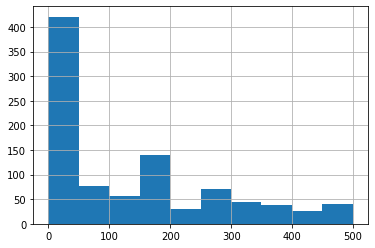

In [178]:
data_smogn['MIC'].hist()

In [179]:
from sklearn.model_selection import cross_val_score

In [180]:
res = []
cv_res = []
for w in ['uniform', 'distance']:
    res_m = []
    cv_res_m = []
    for m in ["euclidean", "manhattan", "chebyshev"]:
        res_k = []
        cv_res_k = []
        for k in range(1,30):
            knn = KNeighborsRegressor(metric=m, n_neighbors=k, weights=w)
            cv_score = cross_val_score(knn, data_smogn.iloc[:,:-1], data_smogn.iloc[:,-1], cv=5,
                                       scoring=mape_scorer)
            cv_mean = cv_score.mean()
            knn = KNeighborsRegressor(metric='euclidean', n_neighbors=k, weights='uniform')
            _ = knn.fit(data_smogn.iloc[:,:-1], data_smogn.iloc[:,-1])
            y_pred = knn.predict(X_test)
            res_k.append(mean_absolute_percentage_error(y_test, y_pred))
            cv_res_k.append(cv_mean)
        res_m.append(res_k)
        cv_res_m.append(cv_res_k)
    res.append(res_m)
    cv_res.append(cv_res_m)
res=np.array(res)
cv_res=np.array(cv_res)

In [181]:
res.min(), cv_res.min()

(6661.807912228103, -939717.7520147755)

In [46]:
knn = KNeighborsRegressor(metric='euclidean', n_neighbors=5, weights='uniform')

In [47]:
_ = knn.fit(data_smogn.iloc[:,:-1], data_smogn.iloc[:,-1])

In [48]:
y_pred = knn.predict(X_test)

In [49]:
mean_absolute_percentage_error(y_test, y_pred)

7632975.598029942

In [54]:
from scipy.stats import pearsonr

In [55]:
pearsonr(y_test, y_pred)

(0.661191812130947, 2.53367270036445e-19)